In [58]:
#Use 13-long gene-diffmat corr to predict symptoms 
#Plot beta-weights (use 13 corr with cmat as control) 
#See symptoms prediction accuracy (diff > cmat)

In [59]:
import pandas as pd
from sklearn import linear_model
import numpy as np
from matplotlib import pyplot as plt
import ants
import os
from tqdm import tqdm
import statistics

In [60]:
cd ../Data/Genemaps

[Errno 2] No such file or directory: '../Data/Genemaps'
/mmfs1/data/pijarj/BC-ORG-Data/Data/Genemaps


In [61]:
#read in symptom patient data and slice out important columns
df = pd.read_csv('/mmfs1/data/pijarj/Data4Julianna/df_patients_S699.csv')
df.columns
df[['ados_total', 'ados_comm', 'ados_social', 'ados_rrb']]

,ados_total,ados_comm,ados_social,ados_rrb
0,18.0,6.0,12.0,2.0
1,NaN,NaN,NaN,NaN
2,13.0,4.0,9.0,NaN
3,12.0,4.0,8.0,2.0
4,16.0,5.0,11.0,3.0
...,...,...,...,...
694,NaN,NaN,NaN,NaN
695,NaN,NaN,NaN,NaN
696,13.0,4.0,9.0,2.0
697,8.0,2.0,6.0,2.0


In [62]:
df.shape

(699, 36)

In [63]:
#load in diffmat data
diffmat = np.load('/mmfs1/data/pijarj/Data4Julianna/recon_asd_diffmats.npz')
diffmat = diffmat['data']
diffmat.shape

(699, 51, 51)

In [64]:
atlas = ants.image_read('../../YeoAtlas/Atlas_parc-7n_2mm.nii')

In [65]:
genemaps = [file for file in os.listdir() if file.endswith('.nii.gz')]
genemaps.sort()

In [66]:
nsubjects = 699
ngenes = len(genemaps)
print(nsubjects)
print(ngenes)

gene_fmri_corr = np.zeros((ngenes,nsubjects))
gene_fmri_corr

699
13


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [67]:
for g in tqdm(range(ngenes)):
    gene_im = ants.image_read(genemaps[g])
    gene_flat = gene_im.numpy().flatten()
    atlas_flat = atlas.numpy().flatten()
    roi_expression = np.array([gene_flat[atlas_flat==roi].mean() for roi in np.arange(1,52)])
    gene_sim = np.zeros((51,51))
    for i in range(51):
        for j in range(51):
            gene_sim[i,j] = abs(roi_expression[i]-roi_expression[j])

    triu = np.triu_indices(51,k=1)
    gene_vec = gene_sim[triu]

    for s in range(nsubjects):
        subject_diffmat = diffmat[s,:,:] # correlation matrices for one subject
        fmri_vec = subject_diffmat[triu]
        data = np.corrcoef(gene_vec,fmri_vec)[0,1]
        gene_fmri_corr[g,s] = data

100%|██████████| 13/13 [00:01<00:00,  6.86it/s]


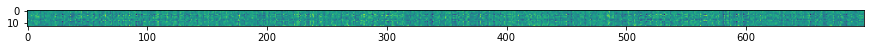

In [68]:
plt.figure(figsize=(15,10))
plt.imshow(gene_fmri_corr)

In [69]:
#change here for each column
col_id = 1

In [70]:
#remove nans
Y = df[['ados_total', 'ados_comm', 'ados_social', 'ados_rrb']].values
print(['ados_total', 'ados_comm', 'ados_social', 'ados_rrb'][col_id]) #column selected
good_subjects = ~np.isnan(Y)[:,col_id]

ados_comm


In [71]:
#separate non-nan subjects in selected column
Y_use = Y[good_subjects,col_id] 
Y_use.shape

(411,)

In [72]:
gene_fmri_corr.shape

(13, 699)

In [73]:
#match non-nan subjects in gene_fmri_corr
X_use = gene_fmri_corr[:,good_subjects]
X_use = X_use.transpose() #match column row size with Y_use
X_use.shape

(411, 13)

In [74]:
#perform multivariate linear aggression
regression =  linear_model.LinearRegression(normalize=True)
regression.fit(X_use,Y_use) 

LinearRegression(normalize=True)

In [75]:
regression.coef_

array([-1.04599854,  0.44164993,  0.86767393, -0.03576914, -0.02514413,
        1.91371414, -0.21080522,  0.4165169 ,  0.837797  ,  0.73880256,
       -1.93477372,  1.08550605, -0.3489913 ])